<a href="https://colab.research.google.com/github/JohnMcKay/Aerial_Image_Segmentation/blob/master/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semantic Segmentation of Aerial Imagery, Authored By John McKay (jmckaypitt@gmail.com)**

In [0]:
# System Imports
import os
import sys
from google.colab import drive  # to mount directory with .shp data

# 3rd Party Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import scipy as sp
import cv2
import matplotlib.pyplot as plt
import tqdm as tqdm
from glob import glob

In [0]:
drive.mount('/content/drive/')  # saved data location
DATA_PATH = '/content/drive/My Drive/sem_seg/short_sample/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def IOU(y_true, y_pred, smooth=100):
    # https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Keras Generator
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Keras Generators for Imagery
class Generator(tf.keras.utils.Sequence):
  def __init__(self, imNames, batch_size, path_to_images):
    self.imNames = imNames
    self.path = path_to_images
    self.batchSize = batch_size
    self.numIms = len(self.imNames)
    self.numSteps = self.numIms // batch_size
    if self.numIms % batch_size == 0:
        self.numSteps -= 1
    #
    self.n = 0
    #
  def __len__(self):
    return self.numSteps
  #
  def __getitem__(self, index):
    if index != self.numSteps:
      imNms = self.imNames[self.batchSize * index:self.batchSize * (index + 1)]
      # lbNms = self.lbNames[self.batchSize * index:self.batchSize * (index + 1)]
    else:
      imNms = self.imNames[self.batchSize * index:]
      # lbNms = self.lbNames[self.batchSize * index:]
    ims = []
    lbs = []
    for i, n in enumerate(imNms):
      temp = cv2.imread(os.path.join(self.path, n))
      temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) * 1.0  # grayscale 
      temp -= temp.min()
      temp /= temp.max()
      ims.append(temp)
      tem2 = cv2.imread(os.path.join(self.path, n.replace('_Image', '_Label')))
      tem2 = cv2.cvtColor(tem2, cv2.COLOR_BGR2GRAY)  # grayscale to collapse labels
      lbs.append(handleLabels(tem2))
    #
    ims = np.array(ims)
    return np.expand_dims(ims, -1), np.array(lbs)
    #
#

# Handle Labels to get into one-hot tensors
def handleLabels(gray_image, label_indicators=[29, 76, 150, 179, 226, 255]):
  labels = np.zeros((gray_image.shape[0], gray_image.shape[1], len(label_indicators)))
  for n, x in enumerate(label_indicators):
    if sum(gray_image.flatten()==x):
      labels[:, :, n] = (gray_image==x).astype(int)
  #
  return labels
#


In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Model Architecture
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def mini_unet(num_classes, input_size=(224, 224, 1), N=1):
  ins = tf.keras.layers.Input(input_size)
  ly1 = tf.keras.layers.Conv2D(32 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ins)
  pl1 = tf.keras.layers.MaxPooling2D()(ly1)
  ly2 = tf.keras.layers.Conv2D(64 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pl1)
  pl2 = tf.keras.layers.MaxPooling2D()(ly2)
  ly3 = tf.keras.layers.Conv2D(128 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pl2)
  dr3 = tf.keras.layers.Dropout(0.5)(ly3)
  pl3 = tf.keras.layers.MaxPooling2D()(ly3)
  # ...
  ly5 = tf.keras.layers.Conv2D(256 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pl3)
  dr5 = tf.keras.layers.Dropout(0.5)(ly5)
  #
  up6 = tf.keras.layers.UpSampling2D((2, 2))(dr5)
  up6 = tf.keras.layers.Conv2D(128 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
  mr6 = tf.keras.layers.concatenate([dr3, up6], axis=3)
  ly6 = tf.keras.layers.Conv2D(128 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(mr6)
  #
  up7 = tf.keras.layers.UpSampling2D((2, 2))(ly6)
  up7 = tf.keras.layers.Conv2D(64 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
  mr7 = tf.keras.layers.concatenate([ly2, up7], axis=3)
  ly7 = tf.keras.layers.Conv2D(64 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(mr7)
  #
  up8 = tf.keras.layers.UpSampling2D((2, 2))(ly7)
  up8 = tf.keras.layers.Conv2D(32 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
  mr8 = tf.keras.layers.concatenate([ly1, up8], axis=3)
  ly8 = tf.keras.layers.Conv2D(32 // N, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(mr8)
  #
  ly9 = tf.keras.layers.Conv2D(num_classes, (3, 3), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(mr8)
  #
  net = tf.keras.Model(ins, ly9)
  #net.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
  net.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=IOU, metrics=['accuracy', 'mse'])
  return net
#

In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Prepare Data
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

BATCH_SIZE = 64
EPOCHS = 4
SPLIT = 0.75

imageNames = glob(os.path.join(DATA_PATH, '*_Image.png'))  # paths to images (labels via Generator)
numClasses = 6  # from inspection
# Shuffle images for training and testing
N = 15000  # len(imageNames)
mixUp = np.random.permutation(N)[:8000]
imageNames = np.array([imageNames[n] for n in mixUp])
trainN = int(len(imageNames) * SPLIT)
testN = len(imageNames) - trainN
# Define generators
trainGenerator = Generator(imageNames[:trainN], BATCH_SIZE, DATA_PATH)
testGenerator = Generator(imageNames[trainN:trainN + testN], BATCH_SIZE, DATA_PATH)
np.save(os.path.join(DATA_PATH, 'trainNames'), imageNames[:trainN])
np.save(os.path.join(DATA_PATH, 'testNames'), imageNames[trainN:trainN + testN])

In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Define Networks
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

net1 = mini_unet(numClasses, N = 1)
net2 = mini_unet(numClasses, N = 1)
net3 = mini_unet(numClasses, N = 2)
net4 = mini_unet(numClasses, N = 4)

In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Train Models
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

net1.fit_generator(generator=trainGenerator, use_multiprocessing=True, workers=8, epochs=EPOCHS)

Epoch 1/4
93/93 [==============================] - 4457s 48s/step - loss: 1.5094 - acc: 0.2925 - mean_squared_error: 0.2531
Epoch 2/4
93/93 [==============================] - 4414s 47s/step - loss: 1.3801 - acc: 0.3679 - mean_squared_error: 0.2196
Epoch 3/4
93/93 [==============================] - 4421s 48s/step - loss: 1.3150 - acc: 0.4050 - mean_squared_error: 0.2199
Epoch 4/4
93/93 [==============================] - 4406s 47s/step - loss: 1.2768 - acc: 0.4229 - mean_squared_error: 0.1979


In [0]:
NET_JSON = os.path.join(DATA_PATH, 'net1_architecture.json')
model_json = net1.to_json()
with open(NET_JSON, "w") as json_file:
    json_file.write(model_json)
#
NET_WEIGHTS = os.path.join(DATA_PATH, 'net1_weights.h5')
net1.save_weights(NET_WEIGHTS)

In [0]:
net2.fit_generator(generator=trainGenerator, use_multiprocessing=True, workers=6, epochs=EPOCHS)

Epoch 1/4
Epoch 1/4
93/93 [==============================] - 4845s 52s/step - loss: 1.5140 - acc: 0.2914 - mean_squared_error: 0.1573
Epoch 2/4
Epoch 2/4
93/93 [==============================] - 4192s 45s/step - loss: 1.3682 - acc: 0.3788 - mean_squared_error: 0.1593
Epoch 3/4
Epoch 3/4
93/93 [==============================] - 4387s 47s/step - loss: 1.2972 - acc: 0.4139 - mean_squared_error: 0.1656
Epoch 4/4
Epoch 4/4
93/93 [==============================] - 4412s 47s/step - loss: 1.2458 - acc: 0.4344 - mean_squared_error: 0.1631


In [0]:
NET_JSON = os.path.join(DATA_PATH, 'net2_architecture.json')
model_json = net2.to_json()
with open(NET_JSON, "w") as json_file:
    json_file.write(model_json)
#
NET_WEIGHTS = os.path.join(DATA_PATH, 'net2_weights.h5')
net2.save_weights(NET_WEIGHTS)

In [0]:
net3.fit_generator(generator=trainGenerator, use_multiprocessing=True, workers=6, epochs=EPOCHS)

Epoch 1/4
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
93/93 [==============================] - 4362s 47s/step - loss: 1.5448 - acc: 0.3043 - mean_squared_error: 0.3308
Epoch 2/4
93/93 [==============================] - 4328s 47s/step - loss: 1.3840 - acc: 0.3440 - mean_squared_error: 0.2701
Epoch 3/4
93/93 [==============================] - 4293s 46s/step - loss: 1.3132 - acc: 0.3874 - mean_squared_error: 0.2272
Epoch 4/4
93/93 [==============================] - 4170s 45s/step - loss: 1.2850 - acc: 0.4006 - mean_squared_error: 0.2066
Epoch 1/4
93/93 [==============================] - 4653s 50s/step - loss: 1.6149 - acc: 0.3077 - mean_squared_error: 0.3010
Epoch 2/4
93/93 [==============================] - 3981s 43s/step - loss: 1.5188 - acc: 0.3083 - mean_squared_error: 0.2816
Epoch 3/4
93/93 [==============================] - 4018s 43s/step - loss: 1.4260 - acc: 0.3181 - mean_squared_error: 0.2533
Epoch 4/4
93/93 [=====================

In [0]:
net4.fit_generator(generator=trainGenerator, use_multiprocessing=True, workers=6, epochs=EPOCHS)

Epoch 1/4
93/93 [==============================] - 4326s 47s/step - loss: 1.9384 - acc: 0.2240 - mean_squared_error: 0.2006
Epoch 2/4
93/93 [==============================] - 4216s 45s/step - loss: 0.9622 - acc: 0.2583 - mean_squared_error: 0.1603
Epoch 3/4
93/93 [==============================] - 4205s 45s/step - loss: 0.9540 - acc: 0.3189 - mean_squared_error: 0.1602
Epoch 4/4
93/93 [==============================] - 4283s 46s/step - loss: 0.9527 - acc: 0.3178 - mean_squared_error: 0.1603


In [0]:
NET_JSON = os.path.join(DATA_PATH, 'net3_architecture.json')
model_json = net3.to_json()
with open(NET_JSON, "w") as json_file:
    json_file.write(model_json)
#
NET_WEIGHTS = os.path.join(DATA_PATH, 'net3_weights.h5')
net3.save_weights(NET_WEIGHTS)


In [0]:
NET_JSON = os.path.join(DATA_PATH, 'net4_architecture.json')
model_json = net4.to_json()
with open(NET_JSON, "w") as json_file:
    json_file.write(model_json)
#
NET_WEIGHTS = os.path.join(DATA_PATH, 'net4_weights.h5')
net4.save_weights(NET_WEIGHTS)

In [0]:
tem2 = cv2.imread(os.path.join(DATA_PATH, imageNames[0].replace('_Image', '_Label')))
tem2 = cv2.cvtColor(tem2, cv2.COLOR_BGR2GRAY)  # grayscale to collapse labels

In [0]:
imageNames = glob(os.path.join(DATA_PATH, '*_Image.png'))  # paths to images (labels via Generator)

len(imageNames)

18029

In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Load Models
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# UNet 1
openJson = open(os.path.join(DATA_PATH, 'net1_architecture.json'), 'r')
unet1_raw = openJson.read()
openJson.close()
unet1 = tf.keras.models.model_from_json(unet1_raw)
unet1.load_weights(os.path.join(DATA_PATH, 'net1_weights.h5'))
# UNet 2
openJson = open(os.path.join(DATA_PATH, 'net2_architecture.json'), 'r')
unet2_raw = openJson.read()
openJson.close()
unet2 = tf.keras.models.model_from_json(unet2_raw)
unet2.load_weights(os.path.join(DATA_PATH, 'net2_weights.h5'))
# UNet 3
openJson = open(os.path.join(DATA_PATH, 'net3_architecture.json'), 'r')
unet3_raw = openJson.read()
openJson.close()
unet3 = tf.keras.models.model_from_json(unet3_raw)
unet3.load_weights(os.path.join(DATA_PATH, 'net3_weights.h5'))
# UNet 4
openJson = open(os.path.join(DATA_PATH, 'net4_architecture.json'), 'r')
unet4_raw = openJson.read()
openJson.close()
unet4 = tf.keras.models.model_from_json(unet4_raw)
unet4.load_weights(os.path.join(DATA_PATH, 'net4_weights.h5'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Prepare Test Data
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

testNames = glob(os.path.join(DATA_PATH, '*_Image.png'))  # paths to images (labels via Generator)
M = 2000 
mixUp = np.arange(N, N+M)  # ensure no overlap with training
testNames = np.array([testNames[n] for n in mixUp])
testData = Generator(testNames, BATCH_SIZE, DATA_PATH)

In [0]:
pred1 = unet1.predict_generator(testData, steps=len(testData), verbose=1, workers=6)

31/31 [==============================] - 1488s 48s/step


In [0]:
a = pred1[0]
b = testData[0]

fig, (p1, p2, p3, p4, p5, p6) = plt.subplots(1,6)
for n, x in enumerate((p1, p2, p3, p4, p5, p6)):
  x.set_title(str(n))
  x.imshow(a[:, :, n])
  x.xaxis.set_visible(False)
  x.yaxis.set_visible(False)

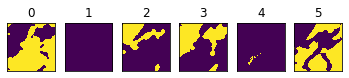

In [0]:
fig, (p1, p2, p3, p4, p5, p6) = plt.subplots(1,6)
for n, x in enumerate((p1, p2, p3, p4, p5, p6)):
  x.set_title(str(n))
  x.imshow(a[:, :, n]>0.5)
  x.xaxis.set_visible(False)
  x.yaxis.set_visible(False)

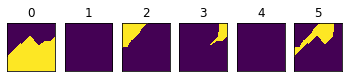

In [0]:
fig, (p1, p2, p3, p4, p5, p6) = plt.subplots(1,6)
for n, x in enumerate((p1, p2, p3, p4, p5, p6)):
  x.set_title(str(n))
  x.imshow(b[1][0, :, :, n])
  x.xaxis.set_visible(False)
  x.yaxis.set_visible(False)

In [0]:
pred2 = unet2.predict_generator(testData, steps=len(testData), verbose=1, workers=6)

31/31 [==============================] - 1395s 45s/step


In [0]:
pred3 = unet3.predict_generator(testData, steps=len(testData), verbose=1, workers=6)

31/31 [==============================] - 1474s 48s/step


In [0]:
pred4 = unet4.predict_generator(testData, steps=len(testData), verbose=1, workers=6)

30/31 [============================>.] - ETA: 52s 

In [0]:
np.save(os.path.join(DATA_PATH, 'pred1', pred1)

In [0]:
np.save(os.path.join(DATA_PATH, 'pred2', pred2)

In [0]:
np.save(os.path.join(DATA_PATH, 'pred3', pred3)

In [0]:
np.save(os.path.join(DATA_PATH, 'pred4', pred4)